# POS Tagging with LSTM

We use the dataset from the [UD English EWT](https://github.com/UniversalDependencies/UD_English-EWT) to train a POS tagger with an LSTM model in English.


## Data Preparation

First, we load the three datasets: train, validation, and test. We use the `conllu` library to parse the datasets.


In [1]:
from conllu import parse

train_filename = "data/english/en_ewt-ud-train.conllu"
test_filename = "data/english/en_ewt-ud-test.conllu"
val_filename = "data/english/en_ewt-ud-dev.conllu"


def get_fields(line):
    words = line.split("\t")
    if len(words) < 4:
        return None
    return words[1], words[3], line


with open(train_filename, "r", encoding="utf-8") as file:
    train_sentences = parse(file.read())
with open(test_filename, "r", encoding="utf-8") as file:
    test_sentences = parse(file.read())
with open(val_filename, "r", encoding="utf-8") as file:
    val_sentences = parse(file.read())

# See the first two sentences as a token list with metadata
train_sentences[:2]

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, ., metadata={newdoc id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000", sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001", newpar id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001", text: "Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border."}>, TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ], metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0002", text: "[This killing of a respected cleric will be causing us trouble for years to come.]"}>]

We preprocess all the datasets by getting only the words and the POS tags. We put all the sentences in a list and all the POS tags in another list of lists. By doing this, we build the 3 datasets to work with the LSTM model.


In [2]:
def preprocess_sentences(sentences):
    X_data = []
    y_data = []
    for sentence in sentences:
        parsed_sentence = []
        sentence_labels = []
        for token in sentence:
            if type(token["id"]) == int:
                parsed_sentence.append(token["form"])
                sentence_labels.append(token["upostag"])
        X_data.append(" ".join(parsed_sentence))
        y_data.append(sentence_labels)

    return X_data, y_data


X_train, y_train = preprocess_sentences(train_sentences)
X_test, y_test = preprocess_sentences(test_sentences)
X_val, y_val = preprocess_sentences(val_sentences)

print(f"Sentences: {X_train[4]}")
print(f"Class labels: {y_train[4]}")

Sentences: The MoI in Iraq is equivalent to the US FBI , so this would be like having J. Edgar Hoover unwittingly employ at a high level members of the Weathermen bombers back in the 1960s .
Class labels: ['DET', 'PROPN', 'ADP', 'PROPN', 'AUX', 'ADJ', 'ADP', 'DET', 'PROPN', 'PROPN', 'PUNCT', 'ADV', 'PRON', 'AUX', 'AUX', 'SCONJ', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADV', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT']


### Data Exploration

We need to make some decisions regarding the model's parameters. For example, we should define the maximum sentence length in the dataset and the size of the vocabulary. Below, we present some statistics about the dataset. It is important to note that this analysis is based solely on the training dataset, as we should not use the validation or test sets for this purpose. Using information from those sets to inform model design could lead to biased results.

#### Maximum Sentence Length

First, we calculate the number of classes and order it by alphabetical order. We obtain 17 different classes (as we expected, because we are following the [Universal POS tags](https://universaldependencies.org/u/pos/index.html) standard). Also, we build a python dictionary to map the POS tags to integers. This dictionary will be used to convert the POS tags to integers and vice versa.


In [3]:
# Flatten y_data and convert to a set to get unique labels
class_names = sorted(list({label for sublist in y_train for label in sublist}))
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Create a dictionary mapping class names to class numbers (classes are ordered alphabetically)
classes = dict(zip(class_names, range(num_classes)))
# For example, class 0 is "ADJ"
print(f"Class number for \"ADJ\": {classes['ADJ']}")

Number of classes: 17
Class names: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Class number for "ADJ": 0


We should make a decission about the maximum length of the sentences. We observe that the average length of the sentences is aproximately 16 words and the standard deviation is 12.4. Also, we observe that there are not a lot of sentences with more than 100 words (only 0.04% of the sentences).


Max sentence length: 159
Mean sentence length: 16.31
Standard deviation of sentence length: 12.4


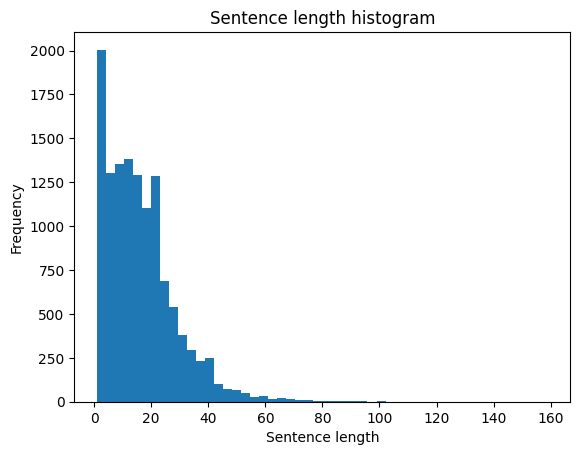

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the maximum length of the sentences
sentence_num_words = [len(sentence.split()) for sentence in X_train]
max_len = max(sentence_num_words)
print(f"Max sentence length: {round(max_len, 2)}")

mean_len = np.mean(sentence_num_words)
std_len = np.std(sentence_num_words)
print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")

# Build an histogram of the number of words in the sentences
plt.hist(sentence_num_words, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.title("Sentence length histogram")
plt.show()

In [5]:
max_sentence_num_words = 100
sentences_over_max_length = [i for i, num_words in enumerate(sentence_num_words) if num_words > max_sentence_num_words]
print(f"Number of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length)}")
print(
    f"Percentage of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length) / len(X_train) * 100:.2f}%\n"
)

for i in sentences_over_max_length:
    print(
        f'Sentence {i} has more than {max_sentence_num_words} words ({sentence_num_words[i]}). Sentence: "{X_train[i]}"'
    )

Number of sentences over 100 words: 5
Percentage of sentences over 100 words: 0.04%

Sentence 6090 has more than 100 words (102). Sentence: "That is what is about to happen with Judge Samuel Alito , in my opinion , because he has one tragic flaw - a very serious blind spot in his thinking - which makes him completely unacceptable for the position of Supreme Court Justice : He does not really agree with the system of " Checks and Balances " built into the Constitution , and he is ready to start tearing it down in order to follow the " Unitary Executive Theory , " which calls for vastly - increased Presidential Power at the expense of Congress and the Supreme Court ."
Sentence 6470 has more than 100 words (104). Sentence: "" I do not feel it has changed the US citizens which is what was needed , even now the majority want " Gas " despite the fact they are polluting the world more than any other country in the world and refuse to stop , perhaps this natural disaster , which let 's face it

As there are only few sentences with more than 100 words, we decide to set the maximum length of the sentences to 100. We will pad the sentences with zeros if they are shorter than 100 words and we will truncate them if they are longer than 100 words. To truncate them we have to options:

- Truncate the sentences from the end of the sentence.
- Locate the last punctuation mark before the token 100 and truncate the sentence from there.


In [6]:
def locate_last_punctuation_mark(sentences_class_labels, limit=None):
    if limit is not None:
        sentences_class_labels = sentences_class_labels[:limit]
    for i, label in enumerate(reversed(sentences_class_labels)):
        if label == "PUNCT":
            return len(sentences_class_labels) - i - 1
    return -1


for i in sentences_over_max_length:
    print(f"Last punctuation mark in sentence {i}: {locate_last_punctuation_mark(y_train[i], limit=100)}")

Last punctuation mark in sentence 6090: 88
Last punctuation mark in sentence 6470: 93
Last punctuation mark in sentence 6724: 84
Last punctuation mark in sentence 6779: 92
Last punctuation mark in sentence 7506: -1


As not all the sentences that overlap the 100 words limit have a punctuation mark at the 100th token, we decide to truncate the sentences from the last punctuation mark before the 100th token, in case there is one. If there is no punctuation mark before the 100th token, we truncate the sentence from the 100th token.


In [7]:
def truncate_sentence(sentence, sentence_class_labels, max_sentence_length=100):
    last_punctuation_mark = locate_last_punctuation_mark(sentence_class_labels, limit=max_sentence_length)
    sentence = sentence.split()[:max_sentence_length]
    sentence_class_labels = sentence_class_labels[:max_sentence_length]
    if last_punctuation_mark != -1:
        sentence = sentence[: last_punctuation_mark + 1]
        sentence_class_labels = sentence_class_labels[: last_punctuation_mark + 1]
    return " ".join(sentence), sentence_class_labels


for i in sentences_over_max_length:
    X_train[i], y_train[i] = truncate_sentence(X_train[i], y_train[i], max_sentence_length=max_sentence_num_words)
    print(f"Lenght of truncated sentence {i}: {len(X_train[i].split())}")

Lenght of truncated sentence 6090: 89
Lenght of truncated sentence 6470: 94
Lenght of truncated sentence 6724: 85
Lenght of truncated sentence 6779: 93
Lenght of truncated sentence 7506: 100


We have to do the same with validation and test datasets. We will use the same maximum length for all the datasets.


In [8]:
sentences_over_max_length_val = [
    i for i, sentence in enumerate(X_val) if len(sentence.split()) > max_sentence_num_words
]
print(
    f"Number of sentences over {max_sentence_num_words} words in the validation set: {len(sentences_over_max_length_val)}"
)

sentences_over_max_length_test = [
    i for i, sentence in enumerate(X_test) if len(sentence.split()) > max_sentence_num_words
]

print(
    f"Number of sentences over {max_sentence_num_words} words in the validation set: {len(sentences_over_max_length_val)}"
)

Number of sentences over 100 words in the validation set: 0
Number of sentences over 100 words in the validation set: 0


In [9]:
def adjust_sentences_length(X_data, y_data, max_sentence_length=100):
    for i in range(len(X_data)):
        if len(X_data[i].split()) > max_sentence_length:
            X_data[i], y_data[i] = truncate_sentence(X_data[i], y_data[i], max_sentence_length=max_sentence_length)
    return


adjust_sentences_length(X_train, y_train, max_sentence_length=max_sentence_num_words)
adjust_sentences_length(X_test, y_test, max_sentence_length=max_sentence_num_words)
adjust_sentences_length(X_val, y_val, max_sentence_length=max_sentence_num_words)

Vexo que os signos de puntuacion non son puntos que rematan frases, deberíamos comprobar isto. Non creo que sexa un problema nin lle preste atencion Catala ao avaliar isto.


In [10]:
for i in sentences_over_max_length:
    index_last_punctuation_mark = locate_last_punctuation_mark(y_train[i], limit=None)
    if index_last_punctuation_mark != -1:
        print(f"Last punctuation mark in sentence {i}: {X_train[i].split()[index_last_punctuation_mark]}")

Last punctuation mark in sentence 6090: -
Last punctuation mark in sentence 6470: "
Last punctuation mark in sentence 6724: ,
Last punctuation mark in sentence 6779: ,


#### Vocabulary Size


We calculated the number of unique words in the training and test sets, which are 19,674 and 5,629, respectively. Notably, many words present in the training set do not appear in the test set. This suggests that it may not be necessary to include all the words from the training set in the vocabulary, as this likely won't impact the model's performance. To determine the optimal vocabulary size, we also analyzed the frequency distribution of words in the training set. We found that only 9,868 words appear more than once in the training set, while the remaining 9,806 words appear only once. This suggests that we could set the vocabulary size to 10,000 without losing much information.


In [11]:
X_plain_train = {token for sentence in X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

Number of unique tokens: 19671
Number of unique tokens: 5629


In [12]:
def calculate_word_frequency(sentences):
    frequencies = dict()

    for sentence in sentences:
        words = sentence.split()
        for word in words:
            if word in frequencies:
                frequencies[word] += 1
            else:
                frequencies[word] = 1
    return frequencies


frequencies = calculate_word_frequency(X_train)
# We count the number of words with more than 1, 2 and 3 occurrences
num_words_gt_1 = sum(1 for word, freq in frequencies.items() if freq > 1)
num_words_gt_2 = sum(1 for word, freq in frequencies.items() if freq > 2)
num_words_gt_3 = sum(1 for word, freq in frequencies.items() if freq > 3)

print(f"Number of words with more than 1 occurrence: {num_words_gt_1}")
print(f"Number of words with more than 2 occurrences: {num_words_gt_2}")
print(f"Number of words with more than 3 occurrences: {num_words_gt_3}")

Number of words with more than 1 occurrence: 9868
Number of words with more than 2 occurrences: 6727
Number of words with more than 3 occurrences: 5142


## Model Design


In [31]:
X_train, y_train = preprocess_sentences(train_sentences)
X_test, y_test = preprocess_sentences(test_sentences)
X_val, y_val = preprocess_sentences(val_sentences)

max_sentence_num_words = 128
sentences_over_max_length = [i for i, num_words in enumerate(sentence_num_words) if num_words > max_sentence_num_words]

for i in sentences_over_max_length:
    X_train[i], y_train[i] = truncate_sentence(X_train[i], y_train[i], max_sentence_length=max_sentence_num_words)

# Map labels
unique_tags = sorted(set(tag for sublist in y_train for tag in sublist))
tag_to_index = {tag: idx for idx, tag in enumerate(unique_tags)}
num_tags = len(tag_to_index)

vocabulary_size = 10000

In [32]:
import tensorflow as tf


# Convert labels into numbers
y_train_indexed = [[tag_to_index[tag] for tag in sublist] for sublist in y_train]
# Add padding to the labels
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train_indexed, padding="post", maxlen=max_sentence_num_words)
y_val_indexed = [[tag_to_index[tag] for tag in sublist] for sublist in y_val]
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val_indexed, padding="post", maxlen=max_sentence_num_words)

# TextVectorization
text_vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int", max_tokens=vocabulary_size, output_sequence_length=max_sentence_num_words
)
text_vectorizer.adapt(X_train)

In [33]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(input_layer)
x = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=50, mask_zero=True)(x)
x = tf.keras.layers.LSTM(units=64, return_sequences=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation="softmax"))(x)
model = tf.keras.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 128)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 128, 50)           500000    
                                                                 
 lstm_2 (LSTM)               (None, 128, 64)           29440     
                                                                 
 time_distributed_2 (TimeDi  (None, 128, 17)           1105      
 stributed)                                                      
                                                                 
Total params: 530545 (2.02 MB)
Trainable params: 530545 (2.

In [34]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
import numpy as np

history = model.fit(
    np.array(X_train), y_train, batch_size=512, epochs=25, validation_data=(np.array(X_val), y_val), verbose=True
)

Epoch 1/25
25/25 [==============================] - 12s 361ms/step - loss: 2.7596 - accuracy: 0.1953 - val_loss: 2.6448 - val_accuracy: 0.2017
Epoch 2/25
25/25 [==============================] - 11s 421ms/step - loss: 2.5662 - accuracy: 0.2005 - val_loss: 2.5182 - val_accuracy: 0.2193
Epoch 3/25
25/25 [==============================] - 11s 435ms/step - loss: 2.4565 - accuracy: 0.2295 - val_loss: 2.3797 - val_accuracy: 0.2632
Epoch 4/25
25/25 [==============================] - 11s 430ms/step - loss: 2.2735 - accuracy: 0.2850 - val_loss: 2.1468 - val_accuracy: 0.3300
Epoch 5/25
25/25 [==============================] - 10s 421ms/step - loss: 2.0501 - accuracy: 0.3638 - val_loss: 1.9227 - val_accuracy: 0.4241
Epoch 6/25
25/25 [==============================] - 10s 421ms/step - loss: 1.8552 - accuracy: 0.4319 - val_loss: 1.7459 - val_accuracy: 0.4821
Epoch 7/25
25/25 [==============================] - 10s 415ms/step - loss: 1.6975 - accuracy: 0.4788 - val_loss: 1.6122 - val_accuracy: 0.5185